# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Цель исследования** — нахождение особенностей и зависимостей, которые существуют на рынке недвижимости, с использованией исследовательского анализа данных.

**Ход исследования**

Данные о поведении пользователей получены из файла `real_estate_data.csv`. О качестве данных ничего не известно, поэтому перед анализом понадобится обзор данных. 
 
Таким образом, исследование пройдёт в четыре этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Добавление новых значений для анализа.
 4. Исследовательский анализ.

## 1 Обзор данных 

### 1.1 Открытие файла

In [1]:
import matplotlib.pyplot as plt # импортируем библиотеку для работы с графикой
import pandas as pd # импортируем библиотеку для работы с данными
import seaborn

data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t') # открываем файл

### 1.2 Изучение общей информации

In [2]:
data.info() # выводим информацию о файле

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
data.head() # выводим первые пять строчек таблицы

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


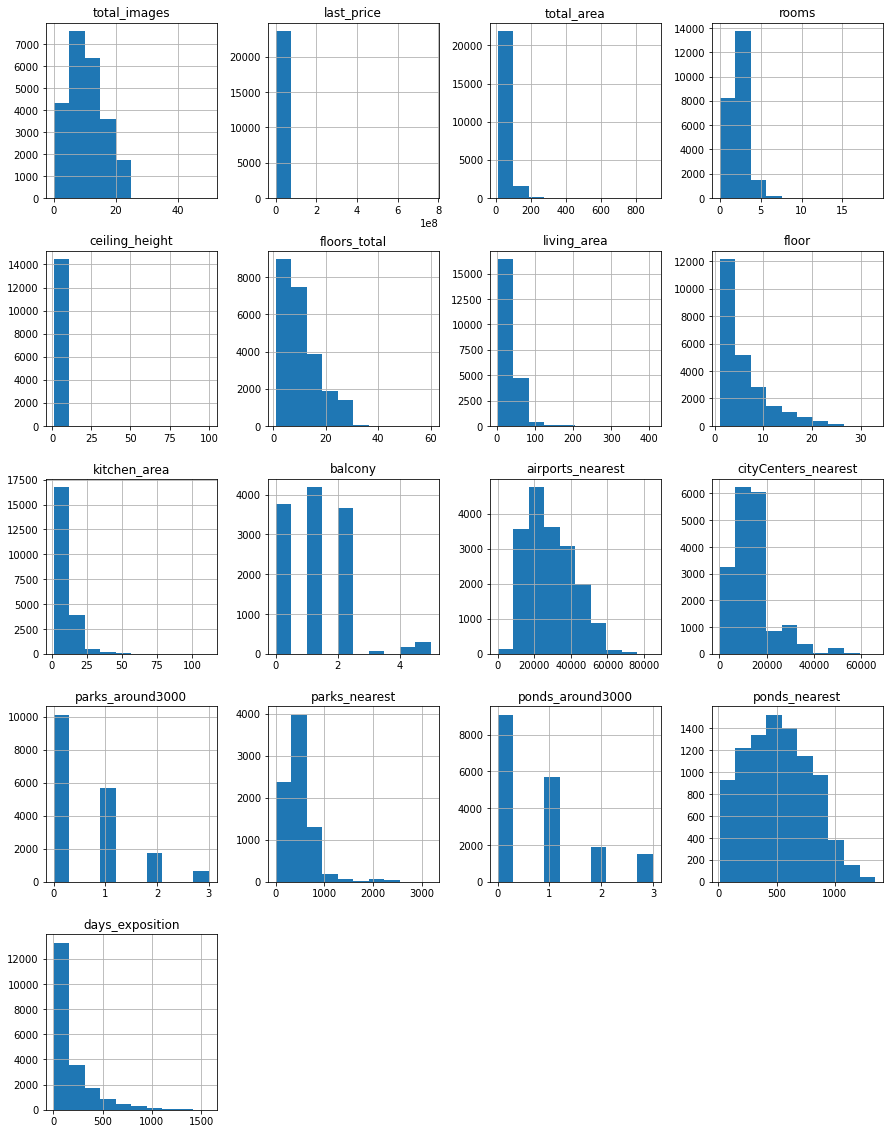

In [4]:
data.hist(figsize=(15, 20)); # строим общую гистограмму для всех столбцов датасета

Для гистограмм, построенных для столбцов со значениями в виде целых чисел и чисел с плавающей точкой, соблюдается распределение Пуассона.

## 2 Предобработка данных

### 2.1 Поиск пропущенных значений

Для изучения пропущенных значений для всей таблицы пройдёмся по списку названий столбцов комбинацией методов `isna()` и `sum()`

In [5]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Видим, что есть столбцы с пропусками. Начнём с тех столбцов, в которых пропуски можно заменить медианными значениями.

In [6]:
columns_to_fill_with_median = ['ceiling_height', 'total_area', 'floors_total', 'living_area', 'kitchen_area'] 
# создаём список с нужными столбцами

for column in columns_to_fill_with_median:
    data[column] = data[column].fillna(data[column].median()) # заполняем медианой

Дальше разберёмся со столбцом `balcony`. Если пользователь, разместивший объявление, ничего не указал, значит, будем считать, что у квартиры, указанной в объявлении, нет балкона. Просто пользователь, скорее всего, забыл указать что-то в этом параметре.

In [7]:
data['balcony'] = data['balcony'].fillna(0)

In [8]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропущенные значения устранены, переходим к столбцу `locality_name`. Это название населённого пункта, поэтому если значение в этом столбце пустое, то его никак не получится заполнить, но и оставлять их значения пустыми нежелательно. Следовательно, строки, в которых этот показатель пуст, нужно удалить.

In [9]:
data = data.dropna(subset = ['locality_name']) # удаляем строки
data.info() # проверяем, правильно ли уменьшилось количество строк после удаления

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Как видно, удалилось ровно 49 строк, в которых не был указан населённый пункт. 

Теперь у нас остались следующие столбцы с пропусками: `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `cityCenters_nearest`, `airports_nearest` и`is_apartment`.

Пропуски в `parks_around3000` и `ponds_around3000` можно заменить на нули. Вероятнее всего, эти параметры были ошибочно не заполнены, так как поблизости нет парков или прудов.

In [10]:
data['parks_around3000'] = data['parks_around3000'].fillna(0) # заполняем значения в столбце для парков
data['ponds_around3000'] = data['ponds_around3000'].fillna(0) # заполняем значения в столбце для прудов

Столбцы `parks_nearest` и `ponds_nearest` следует оставить нетронутыми, так как расстояние от недвижимости до этих объектов очень сильно зависит от точного местоположения этой самой недвижимости. 

Столбцы `days_exposition`, `airports_nearest` и `cityCenters_nearest` также оставляем, неясно, что с ними делать.

Столбец `is_apartment` тоже оставим, так как понятие апартаментов очень размытое.

### 2.2 Изменение типов данных

В некоторых столбцах в нашей таблице можно поменять типы с вещественного на целочисленный. 

Так, например, такая замена логична для столбцов `floors_total`, `balcony`, `parks_around3000` и `ponds_around3000`, потому что эти столбцы просто-напросто не могут быть вещественными. 

In [11]:
columns_to_change_type_of = ['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000', 'last_price']
# создаём список

for column in columns_to_change_type_of:
    data[column] = data[column].astype(int) # меняем тип

In [12]:
data.info() # проверяем смену типа

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  int64  
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  int64  
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  int64  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Также заменим тип `first_day_exposition` на тип даты.

In [13]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Типы данных были изменены, можем перейти к следующему шагу предобработки данных.

### 2.3 Устранение неявных дубликатов

Рассмотрим значения в столбце `locality_name`

In [14]:
data['locality_name'].value_counts()

Санкт-Петербург                  15721
посёлок Мурино                     522
посёлок Шушары                     440
Всеволожск                         398
Пушкин                             369
                                 ...  
посёлок Сумино                       1
деревня Кисельня                     1
садовое товарищество Садко           1
деревня Пчева                        1
поселок Пансионат Зелёный Бор        1
Name: locality_name, Length: 364, dtype: int64

In [15]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Из этого списка видно, что в этом столбце возникли дубликаты вследствии разницы в написании букв 'е' и 'ё' в слове 'посёлок'.
Унифицируем написание этого слова, заменив все 'е' на 'ё'

In [16]:
data['locality_name'] = data['locality_name'].replace("поселок", "посёлок", regex = True)
data['locality_name'].value_counts()

Санкт-Петербург           15721
посёлок Мурино              556
посёлок Шушары              440
Всеволожск                  398
Пушкин                      369
                          ...  
посёлок Плоское               1
деревня Зимитицы              1
посёлок Петро-Славянка        1
деревня Кисельня              1
посёлок Кирпичное             1
Name: locality_name, Length: 330, dtype: int64

In [17]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской посёлок Большая Ижора', 'городской посёлок Будогощь',
       'городской посёлок Виллози', 'городской посёлок Лесогорский',
       'городской посёлок Мга', 'городской посёлок Назия',
       'городской посёлок Новоселье', 'городской посёлок Павлово',
       'городской посёлок Рощино', 'городской посёлок Свирьстрой',
       'городской посёлок Советский', 'городской посёлок Фёд

In [18]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20890
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000            0
parks_nearest           15586
ponds_around3000            0
ponds_nearest           14565
days_exposition          3180
dtype: int64

### 2.4 Обработка и удаление аномалий

Посмотрим на значения в столбце `ceiling_height`.

In [19]:
sorted(data['ceiling_height'].unique())

[1.0,
 1.2,
 1.75,
 2.0,
 2.2,
 2.25,
 2.3,
 2.34,
 2.4,
 2.45,
 2.46,
 2.47,
 2.48,
 2.49,
 2.5,
 2.51,
 2.52,
 2.53,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.59,
 2.6,
 2.61,
 2.62,
 2.63,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.7,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,
 3.9,
 3.93,
 3.95,
 3.98,

Для начала обработаем явные аномалии - значения больше либо равные 10, поделив эти значения на 10 увидим значения, которые близки к реальным. Оставшиеся значения, которые не лежат в диапазоне от 2.4 до 3.2 метров (стандарт высоты комнат), можно смело удалять.

In [20]:
reduced_height_data = data.loc[(data['ceiling_height'] >= 10), 'ceiling_height'] / 10 
# создаём срез с уменьшенными в 10 раз значениями

for ind in reduced_height_data.index:
    data.loc[ind, 'ceiling_height'] = reduced_height_data[ind] # в цикле заменяем строки из оригинальной таблицы на новые значения 

data = data.query('ceiling_height > 2.4 & ceiling_height < 3.2') # отбрасываем лишние значения

In [21]:
sorted(data['ceiling_height'].unique()) # проверяем диапазон значений высоты потолка

[2.45,
 2.46,
 2.47,
 2.48,
 2.49,
 2.5,
 2.51,
 2.52,
 2.53,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.59,
 2.6,
 2.61,
 2.62,
 2.63,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.7,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18]

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22532 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22532 non-null  int64         
 1   last_price            22532 non-null  int64         
 2   total_area            22532 non-null  float64       
 3   first_day_exposition  22532 non-null  datetime64[ns]
 4   rooms                 22532 non-null  int64         
 5   ceiling_height        22532 non-null  float64       
 6   floors_total          22532 non-null  int64         
 7   living_area           22532 non-null  float64       
 8   floor                 22532 non-null  int64         
 9   is_apartment          2600 non-null   object        
 10  studio                22532 non-null  bool          
 11  open_plan             22532 non-null  bool          
 12  kitchen_area          22532 non-null  float64       
 13  balcony         

Посмотрим на "ящик с усами" для столбца с числом комнат.

<AxesSubplot:>

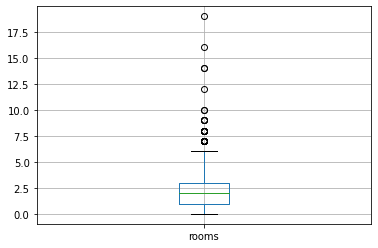

In [23]:
data.boxplot('rooms')

Видно, что нижний "ус" в 0, минимальное значение. Верхний же "ус" упирается в 6, все остальные значения можно считать выбросами.

In [24]:
data = data.query('rooms > 0 & rooms <= 6') # отбрасываем 0, так как такого количества комнат просто не может быть

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22297 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22297 non-null  int64         
 1   last_price            22297 non-null  int64         
 2   total_area            22297 non-null  float64       
 3   first_day_exposition  22297 non-null  datetime64[ns]
 4   rooms                 22297 non-null  int64         
 5   ceiling_height        22297 non-null  float64       
 6   floors_total          22297 non-null  int64         
 7   living_area           22297 non-null  float64       
 8   floor                 22297 non-null  int64         
 9   is_apartment          2592 non-null   object        
 10  studio                22297 non-null  bool          
 11  open_plan             22297 non-null  bool          
 12  kitchen_area          22297 non-null  float64       
 13  balcony         

In [26]:
print('\nЧисло дубликатов:', data.duplicated().sum())


Число дубликатов: 0


**Вывод:** Была проведена предобработка данных, а именно: работа с пропущенными значениями, изменение типов данных, удаление аномалий и устранение неявных.

## 3 Добавление новых признаков

In [27]:
data['price_per_square_meter'] = data['last_price'] / data['total_area'] # цена одного квадратного метра
data['price_per_square_meter'] = data['price_per_square_meter'].astype('int')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22297 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            22297 non-null  int64         
 1   last_price              22297 non-null  int64         
 2   total_area              22297 non-null  float64       
 3   first_day_exposition    22297 non-null  datetime64[ns]
 4   rooms                   22297 non-null  int64         
 5   ceiling_height          22297 non-null  float64       
 6   floors_total            22297 non-null  int64         
 7   living_area             22297 non-null  float64       
 8   floor                   22297 non-null  int64         
 9   is_apartment            2592 non-null   object        
 10  studio                  22297 non-null  bool          
 11  open_plan               22297 non-null  bool          
 12  kitchen_area            22297 non-null  float6

In [29]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday # день недели публикации

data['month_exposition'] = data['first_day_exposition'].dt.month # месяц публикации

data['year_exposition'] = data['first_day_exposition'].dt.year # год публикации

Далее необходимо написать функцию категоризации квартир по типу этажа и применить её к значениям столбца.

In [30]:
# пишем функцию
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
    
data['floor_category'] = data.apply(floor_category, axis = 1) # применяем функцию

In [31]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] / 1000 # переводим из метров в километры
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].round() # округляем до целых значений

In [32]:
print(data.head()) # проверяем, правильно ли были добавлены столбцы

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20    13000000       108.0           2019-03-07      3   
1             7     3350000        40.4           2018-12-04      1   
2            10     5196000        56.0           2015-08-20      2   
3             0    64900000       159.0           2015-07-24      3   
4             2    10000000       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70            16         51.0      8          NaN  ...   
1            2.65            11         18.6      1          NaN  ...   
2            2.65             5         34.3      4          NaN  ...   
3            2.65            14         30.0      9          NaN  ...   
4            3.03            14         32.0     13          NaN  ...   

   parks_nearest  ponds_around3000  ponds_nearest  days_exposition  \
0          482.0                 2          755.0              N

**Вывод:** столбцы были добавлены правильно, предобработка данных завершена. Можно переходить к исследовательскому анализу данных

## 4 Исследовательский анализ данных

### 4.1 Изучение параметров объектов

**Общая площадь**

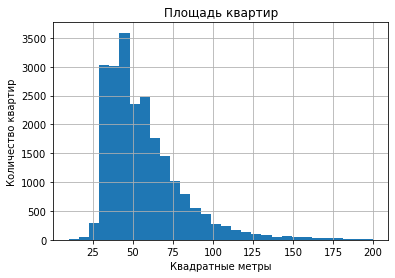

In [33]:
# Работаем с площадью
data['total_area'].describe()
data['total_area'].hist(bins=30, range=(10, 200))
plt.title('Площадь квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

Большинство значений площади квартир лежит в диапазоне между 25 и 95 квадратными метрами

**Жилая площадь**

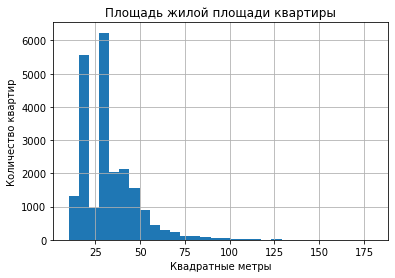

In [34]:
# Работаем с жилой площадью
data['living_area'].describe()
data['living_area'].hist(bins=30, range=(10, 180))
plt.title('Площадь жилой площади квартиры')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

Большинство значений жилой площади квартир лежит в диапазоне между 10 и 55 квадратными метрами.

**Площадь кухни**

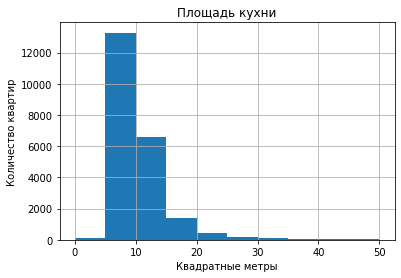

In [35]:
# Работаем с площадью кухни
data['kitchen_area'].describe()
data['kitchen_area'].hist(range = (0, 50))
plt.title('Площадь кухни')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

Большинство значений площади кухни лежит в диапазоне между 5 и 15 квадратными метрами.

**Цена объекта**

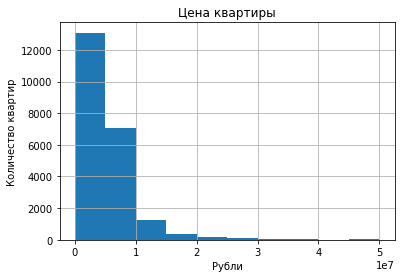

In [36]:
# Работаем с ценой объекта
data['last_price'].describe()
data['last_price'].hist(range=(1.000000e+04, 5.000000e+07))
plt.title('Цена квартиры')
plt.xlabel('Рубли')
plt.ylabel('Количество квартир')
plt.show()

Большинство значений стоимости квартиры лежит в пределах 10 миллиона рублей.

**Количество комнат**

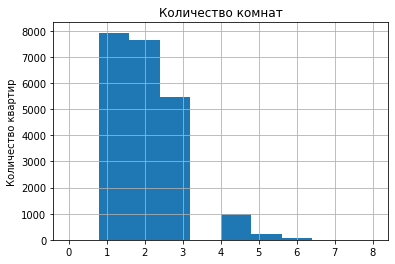

In [37]:
# Работаем с количеством комнат
data['rooms'].describe()
data['rooms'].hist(range = (0, 8))
plt.title('Количество комнат')
plt.xlabel('')
plt.ylabel('Количество квартир')
plt.show()

В среднем, в квартирах преимущественно есть от 1-ой до 3-ёх комнат

**Высота потолков**

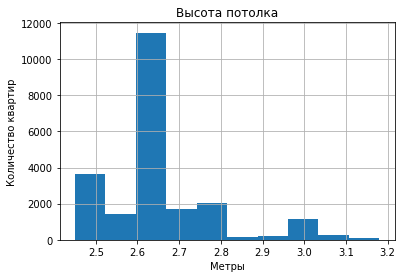

In [38]:
# Работаем с высотой потолков
data['ceiling_height'].describe()
data['ceiling_height'].hist()
plt.title('Высота потолка')
plt.xlabel('Метры')
plt.ylabel('Количество квартир')
plt.show()

Средняя высота потолка равна 2.64 метрам

**Этаж квартиры**

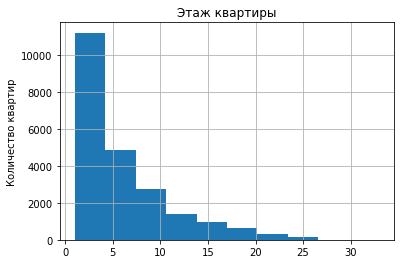

In [39]:
# Работаем с этажом квартиры
data['floor'].describe()
data['floor'].hist()
plt.title('Этаж квартиры')
plt.xlabel('')
plt.ylabel('Количество квартир')
plt.show()

В среднем квартиры распологаются на этажах до 10, что логично, потому что девятиэтажных домов гораздо больше, чем более высоких многоэтажек.

**Тип этажа квартиры**

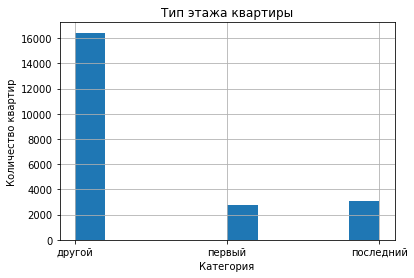

In [40]:
# Работаем с типом этажа квартиры
data['floor_category'].describe()
data['floor_category'].hist()
plt.title('Тип этажа квартиры')
plt.xlabel('Категория')
plt.ylabel('Количество квартир')
plt.show()

Около 80% квартир располагается не на первом и не на последнем этажах.

**Общее количество этажей в доме**

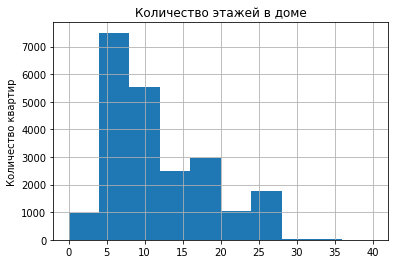

In [41]:
# Работаем с общим количеством этажей в доме
data['floors_total'].describe()
data['floors_total'].hist(range = (0, 40))
plt.title('Количество этажей в доме')
plt.xlabel('')
plt.ylabel('Количество квартир')
plt.show()

Больше всего в выборке объявлений находятся пятиэтажные этажи.

**Расстояние до центра города**

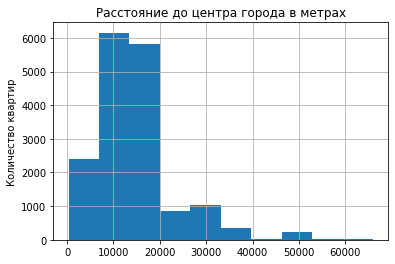

In [42]:
# Работаем с расстоянием до центра города
data['cityCenters_nearest'].describe()
data['cityCenters_nearest'].hist()
plt.title('Расстояние до центра города в метрах')
plt.xlabel('')
plt.ylabel('Количество квартир')
plt.show()

Большинство квартир расположено в пределах 20 километров от центра своего населённого пункта.

**Расстояние до ближайшего аэропорта**

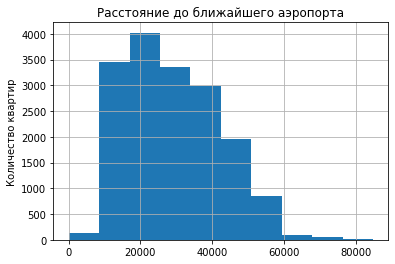

In [43]:
# Работаем с расстоянием до ближайшего аэропорта
data['airports_nearest'].describe()
data['airports_nearest'].hist()
plt.title('Расстояние до ближайшего аэропорта')
plt.xlabel('')
plt.ylabel('Количество квартир')
plt.show()


Большинство квартир расположено на расстоянии до 50 километров от аэропортов, непосредственно вблизи от них находится около 1% квартир.

**Расстояние до ближайшего парка**

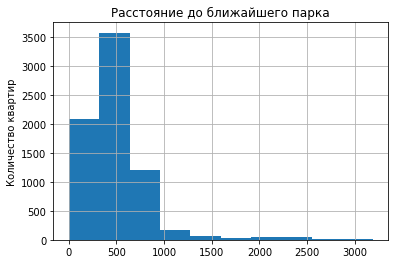

In [44]:
# Работаем с расстоянием до ближайшего парка
data['parks_nearest'].describe()
data['parks_nearest'].hist()
plt.title('Расстояние до ближайшего парка')
plt.xlabel('')
plt.ylabel('Количество квартир')
plt.show()

В среднем ближайшие парки находятся на расстоянии до 600 метров от недвижимости.

**День публикации объявления**

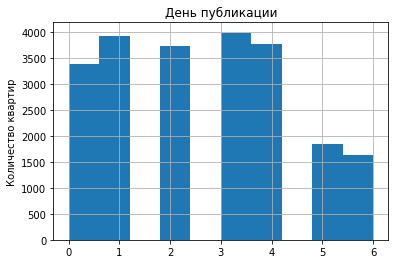

In [45]:
# Работаем с днём публикации объявления
data['weekday_exposition'].describe()
data['weekday_exposition'].hist()
plt.title('День публикации')
plt.xlabel('')
plt.ylabel('Количество квартир')
plt.show()

Чаще всего объявления публикуют в будние дни, на выходных - в два раза реже, чем обычно.

**Месяц публикации объявления**

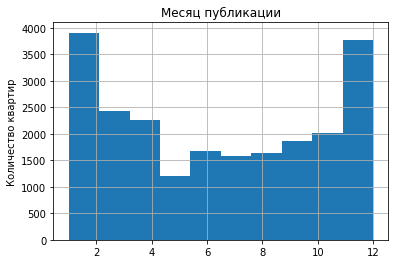

In [46]:
# Работаем с месяцем публикации объявления
data['month_exposition'].describe()
data['month_exposition'].hist()
plt.title('Месяц публикации')
plt.xlabel('')
plt.ylabel('Количество квартир')
plt.show()

Чаще всего объявления публикуются в январе и декабре. Скорее всего, это связано с новогодними праздниками.

#### Изучение времени продажи квартиры

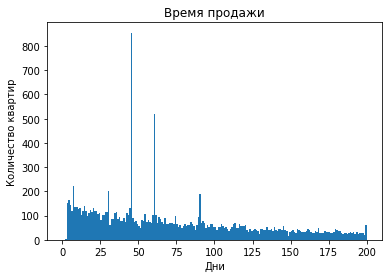

Время продажи (медиана): 93 

Время продажи (среднее): 177 



count    19404.000000
mean       177.419501
std        216.594070
min          1.000000
25%         44.000000
50%         93.000000
75%        225.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [47]:
# Гистограма времени продажи
plt.hist(data['days_exposition'], bins=200, range=(0, 200))
plt.title('Время продажи')
plt.xlabel('Дни')
plt.ylabel('Количество квартир')
plt.show()
# Вычисляем среднее и медиану
print('Время продажи (медиана):', round(data['days_exposition'].median()),'\n')
print('Время продажи (среднее):', round(data['days_exposition'].mean()),'\n')
# Изучаем значения срока продажи
data['days_exposition'].describe()

In [48]:
data['days_exposition'].value_counts()

45.0      855
60.0      520
7.0       223
30.0      200
90.0      187
         ... 
985.0       1
1452.0      1
1280.0      1
844.0       1
1174.0      1
Name: days_exposition, Length: 1121, dtype: int64

Видим, что очень большое количество элементов приходится на значения в 45 и 60 дней. Возможно, это связано с тем, что спустя 1.5-2 месяца продавец сбрасывает цену на недвижимость.

Раз медианное значение близко к 100, то возьмём его за норму. Тогда время продажи в 50 дней можно считать быстрым, а в 200 дней - необычайно долгим. 

### 4.2 Выявление факторов, влияющих на полную стоимость объекта

**Зависимость цены от общей площади квартиры**

0.6929026701383136

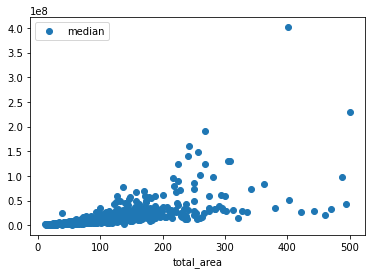

In [49]:
pivot_table_total_area = data.pivot_table(index = 'total_area', values = 'last_price',
                                          aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

pivot_table_total_area.sort_values('median', ascending = False)

data['total_area'].corr(data['last_price'])

Корреляция положительная и сильная. Чем больше общая площадь квартиры, тем больше цена этой квартиры.

**Зависимость цены от жилой площади квартиры**

0.5433484668337905

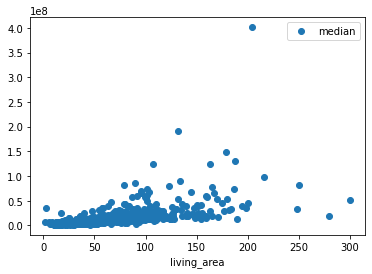

In [50]:
pivot_table_living_area = data.pivot_table(index = 'living_area', values = 'last_price',
                                           aggfunc = ['mean', 'count', 'median'])
pivot_table_living_area.columns = ['mean', 'count', 'median']
pivot_table_living_area.plot(y = 'median', style = 'o')

pivot_table_living_area.sort_values('median', ascending = False)

data['living_area'].corr(data['last_price'])

Корреляция положительная и умеренная. Чем больше жилая площадь квартиры, тем слегка больше цена этой квартиры.

**Зависимость цены от площади кухни**

0.4715527389637356

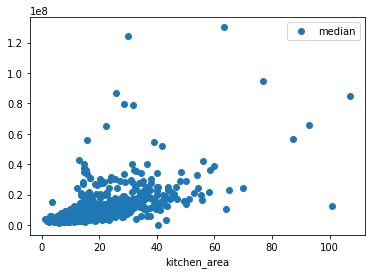

In [51]:
pivot_table_kitchen_area = data.pivot_table(index = 'kitchen_area', values = 'last_price',
                                           aggfunc = ['mean', 'count', 'median'])

pivot_table_kitchen_area.columns = ['mean', 'count', 'median']
pivot_table_kitchen_area.plot(y = 'median', style = 'o')

pivot_table_kitchen_area.sort_values('median', ascending = False)

data['kitchen_area'].corr(data['last_price'])

Корреляция положительная и умеренная. Чем больше площадь кухни, тем слегка больше цена квартиры.

**Зависимость цены от количества комнат**

               mean  count    median
rooms                               
1      3.806269e+06   7928   3600000
2      5.394552e+06   7637   4700000
3      7.756762e+06   5451   6000000
4      1.227160e+07    999   8490000
5      2.206971e+07    216  13000000
6      2.701780e+07     66  17879300


0.3770978738424616

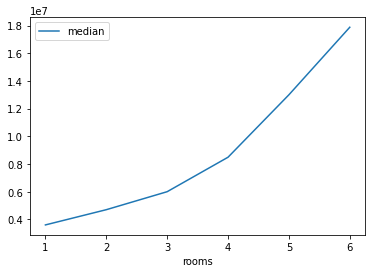

In [52]:
pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'last_price',
                                     aggfunc = ['mean', 'count', 'median'])

pivot_table_rooms.columns = ['mean', 'count', 'median']

print(pivot_table_rooms.head(1000))
pivot_table_rooms.plot(y = 'median')

pivot_table_rooms.sort_values('median', ascending = False)

data['rooms'].corr(data['last_price'])

Чем больше комнат в квартире, тем больше стоимость квартиры.

**Зависимость цены от типа этажа**

,mean,count,median
floor_category,,,
другой,6.196195e+06,16435,4750000
первый,4.475285e+06,2758,3850000
последний,5.885512e+06,3069,4150000


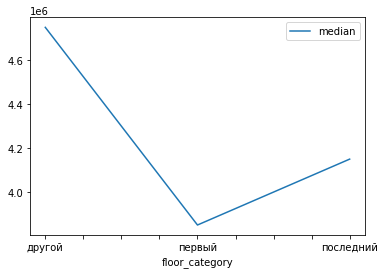

In [53]:
pivot_table_floor_category = data.pivot_table(index = 'floor_category', values = 'last_price', 
                                              aggfunc = ['mean', 'count', 'median'])

pivot_table_floor_category.columns = ['mean', 'count', 'median']
pivot_table_floor_category.plot(y = 'median')

pivot_table_floor_category

Разница между ценой квадратного метра у первого и последнего этажей - примерно 6%.

**Зависимость цены от дня недели размещения объявления**

,mean,count,median
weekday_exposition,,,
1,5.887919e+06,3939,4640000
2,5.922732e+06,3730,4600000
0,5.832748e+06,3390,4550000
3,6.048806e+06,3993,4500000
4,5.924968e+06,3771,4500000
5,6.068956e+06,1847,4500000
6,5.963949e+06,1627,4500000


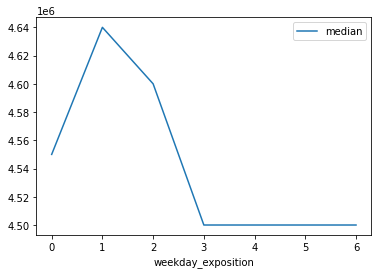

In [54]:
pivot_table_weekday_exposition = data.pivot_table(index = 'weekday_exposition',
                                                  values = 'last_price',
                                                  aggfunc = ['mean', 'count', 'median'])

pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')

pivot_table_weekday_exposition.sort_values('median', ascending = False)

Видно, что чем ближе ко вторнику выставлены объявления, тем в среднем выше стоимость, но незначительно.

**Зависимость цены от месяца размещения объявления**

,mean,count,median
month_exposition,,,
4,5.899783e+06,2251,4700000
11,6.107081e+06,2231,4650000
9,5.987166e+06,1854,4600000
12,6.095949e+06,1533,4600000
2,6.030978e+06,2496,4550000
3,5.835755e+06,2430,4550000
1,6.043374e+06,1409,4500000
5,6.070796e+06,1196,4500000
7,5.837820e+06,1572,4500000


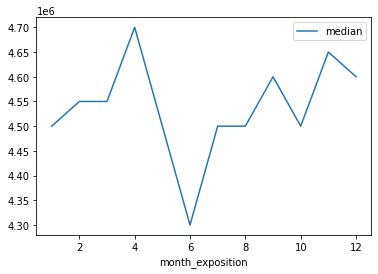

In [55]:
pivot_table_month_exposition = data.pivot_table(index = 'month_exposition',
                                                values = 'last_price',
                                                aggfunc = ['mean', 'count', 'median'])

pivot_table_month_exposition.columns = ['mean', 'count', 'median']
pivot_table_month_exposition.plot(y = 'median')

pivot_table_month_exposition.sort_values('median', ascending = False)

Cамая высокая стоимость метра в апреле, сентябре и ноябре, в то время как самая низкая стоимость в мае, июне, июле и августе. Скорее всего, связано с дачным периодом и/или рабочими отпусками.

**Зависимость цены от года размещения объявления**

,mean,count,median
year_exposition,,,
2014,1.149045e+07,127,7500000
2015,7.303423e+06,1083,5100000
2019,6.113388e+06,2707,4950000
2018,5.576465e+06,8082,4500000
2017,5.827470e+06,7679,4412094
2016,6.387933e+06,2619,4400000


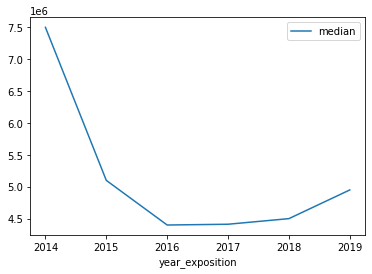

In [56]:
pivot_table_year_exposition = data.pivot_table(index = 'year_exposition',
                                               values = 'last_price',
                                               aggfunc = ['mean', 'count', 'median'])

pivot_table_year_exposition.columns = ['mean', 'count', 'median']
pivot_table_year_exposition.plot(y = 'median')

pivot_table_year_exposition.sort_values('median', ascending = False)

Цена на квартиры сильно упала после 2014 года. Возможно, такая аномалия зависит не от года. Проверим зависимости других значений от года размещения объявления. 

,mean,count,median
year_exposition,,,
2014,83.549055,127,75.5
2015,66.161283,1083,58.0
2016,59.409156,2619,52.0
2017,57.925493,7679,51.0
2019,56.632324,2707,51.0
2018,56.104337,8082,50.0


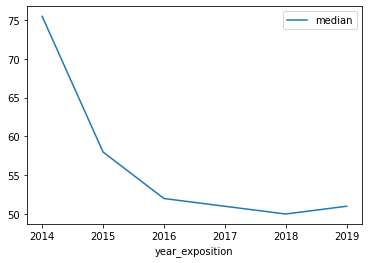

In [57]:
pivot_table_year_exposition_with_total_area = data.pivot_table(index = 'year_exposition', 
                                                               values = 'total_area', 
                                                               aggfunc = ['mean', 'count', 'median'])

pivot_table_year_exposition_with_total_area.columns = ['mean', 'count', 'median']
pivot_table_year_exposition_with_total_area.plot(y = 'median')

pivot_table_year_exposition_with_total_area.sort_values('median', ascending = False)

Видно, что линия на этом графике похожа на линию из предыдущего графика. Можно сделать вывод, что цена не зависит от года размещения квартиры, но зависит от общей площади квартиры (данную закономерность мы уже выявили ранее).

#### Подсчёт средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [58]:
locality_pivot_table = data.pivot_table(index = 'locality_name',
                                        values = 'price_per_square_meter',
                                        aggfunc = ['count', 'mean', 'median'])
locality_pivot_table.columns = ['count', 'mean', 'median']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)

print(locality_pivot_table)

print(locality_pivot_table[locality_pivot_table['median'] == locality_pivot_table['median'].max()]) #самая высокая стоимость

print(locality_pivot_table[locality_pivot_table['median'] == locality_pivot_table['median'].min()]) #самая низкая стоимость

                   count           mean    median
locality_name                                    
Санкт-Петербург    14571  112356.695148  104005.0
посёлок Мурино       529   85003.597353   84239.0
посёлок Шушары       435   78382.186207   76666.0
Всеволожск           388   68570.873711   65737.5
Пушкин               349  102387.848138   99987.0
Колпино              330   75439.484848   74729.0
посёлок Парголово    322   90448.000000   91984.0
Гатчина              304   68665.394737   67745.5
деревня Кудрово      283   92296.749117   91666.0
Выборг               223   57835.852018   57613.0
                 count           mean    median
locality_name                                  
Санкт-Петербург  14571  112356.695148  104005.0
               count          mean   median
locality_name                              
Выборг           223  57835.852018  57613.0


Населённый пункты с самой высокой стоимостью квадратного метра - Санкт-Петербург, а с самой низкой - Выборг.

#### Средняя цена километра

In [59]:
SPb = data.query('locality_name == "Санкт-Петербург"')

km_mean_cost = SPb.pivot_table(index = 'cityCenters_nearest_km',
                                values = 'price_per_square_meter',
                                aggfunc = 'mean')

print(km_mean_cost.sort_values('price_per_square_meter', ascending = False))

                        price_per_square_meter
cityCenters_nearest_km                        
0.0                              316428.916667
7.0                              151532.047745
2.0                              150898.929348
1.0                              149403.297521
6.0                              146837.728682
5.0                              143586.264957
27.0                             132115.000000
4.0                              130327.062622
8.0                              124441.818182
3.0                              121786.138393
10.0                             112734.732475
9.0                              112474.653097
11.0                             108400.973299
13.0                             107909.760642
12.0                             107360.348896
15.0                             104168.004522
14.0                             104019.961814
20.0                             101390.913043
16.0                             100375.506816
19.0         

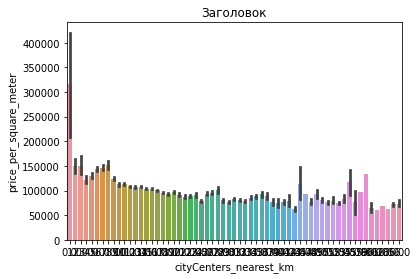

In [62]:
km_mean_cost = km_mean_cost.sort_values(by = 'cityCenters_nearest_km')

seaborn.barplot(data = data, x = 'cityCenters_nearest_km', y = 'price_per_square_meter')
plt.title('Заголовок')
plt.show()

Чем ближе квартира к центру, тем дороже она стоит, хотя и встречаются исключения из этого правила.

**Вывод:** был проведён исследовательский анализ данных, выявлены некоторые закономерности.

### Общий вывод

Был обработан датасет с данными об объявлениях о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

Была произведена предобработка данных - обработаны пропущенные значения там, где это необходимо, заменены типы данных на необходимые для удобной работы. Посчитаны и добавилены в таблицу следующие столбцы: цена квадратного метра жилья; день, месяц и год недели размещения объявлений, выведенные из даты размещения; тип этажа квартиры; расстояние до центра населённого пункта в километрах.

Были изучены следующие параметры на наличие выбивающихся значений - площадь, цена, число комнат, высота потолков. Были определены аномалии в данных параметрах. 

Было выявлено, что нормальные значения продажи квартир варьируются от 1 до 600 дней. 

Было установлено, что на стоимость квадратного метра квартиры больше всего влияют следующие параметры: жилая, общая площади квартиры вместе с площадью кухни, количество комнат, близость к центру и этаж квартиры. Незначительно на стоимость квадратного метра влияют остальные параметры: день, месяц, год размещения объявления о продаже.

Было обнаружено падение цены в 2015 году, но данное наблюдение было связано с уменьшением площадей 